In [14]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError

%matplotlib inline

sns.set()

# Anomaly detection in NHAMCS data

## Loading the dataset

The NHAMCS dataset is loaded, where aach row represents a patient visit. All columns except those related to the date of the visit and the reason for the visit are discarded. The primary reason for visit column (RFV1) is categorical, with each symptom being assigned a unique numeric code.

Here, the visit year, month, and day are combined into a datetime and the original date columns are discarded.

In [15]:
years = [
    2015,
    2016,
    2017,
    2018,
]

cols = [
    'VMONTH',
    'VDAYR',
    'RFV1',
]

col_rename = {
    'VMONTH': 'month',
    'VDAYR': 'day',
}

na = {
    'RFV1': -9,
}

def get_nhamcs_data(years):
    for year in years:
        df = pd.read_csv(
            os.path.join('data', 'nhamcs{}.csv'.format(year)),
            usecols=cols,
            na_values=na,
        )
        df['year'] = year
        yield df

frames = list(get_nhamcs_data(years))
nhamcs = pd.concat(frames, join='inner', ignore_index=True)

nhamcs.rename(columns=col_rename, inplace=True)
nhamcs['date'] = pd.to_datetime(nhamcs[['year', 'month', 'day']])
nhamcs.drop([
        'year',
        'month',
        'day',
    ],
    axis=1,
    inplace=True,
)

nhamcs.head(5)

,RFV1,date
0,19351.0,2015-11-02
1,52250.0,2015-11-02
2,12100.0,2015-11-03
3,19451.0,2015-11-04
4,19601.0,2015-11-04


## Creating feature vectors

The reasons for the visit are restricting to only those associated with flu-like symptoms. The categorical information is replaced with a new one-hot encoding, with one column for each symptom.

To create the feature vectors, the data are grouped by date with each row representing a day and each column a unique symptom. For each day, the number of patients visiting for each symptom are summed, and then divided by the total number of visits.

In [16]:
import rfv

nhamcs = nhamcs[nhamcs["RFV1"].isin(rfv.rfv1)].reindex()

onehot = pd.get_dummies(nhamcs['RFV1'], prefix='RFV')
nhamcs.drop('RFV1', axis=1, inplace=True)
nhamcs = nhamcs.join(onehot)

syndromic_features = nhamcs.groupby('date').sum().apply(lambda row: row/float(row.sum()))
syndromic_features.head()

,RFV_10050.0,RFV_10100.0,RFV_10150.0,RFV_10200.0,RFV_10250.0,RFV_10300.0,RFV_10350.0,RFV_10352.0,RFV_10353.0,RFV_10500.0,...,RFV_14851.0,RFV_15250.0,RFV_15300.0,RFV_15350.0,RFV_15400.0,RFV_15450.0,RFV_15451.0,RFV_16150.0,RFV_19651.0,RFV_46050.0
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.000000,0.001638,0.000000,0.004208,0.005291,0.005660,0.011111,0.0,0.0,0.0,...,0.0,0.003594,0.002099,0.0,0.0,0.000000,0.003647,0.019608,0.0,0.008065
2015-01-02,0.017241,0.003932,0.000000,0.004208,0.005291,0.003774,0.000000,0.0,0.0,0.0,...,0.0,0.003594,0.002099,0.0,0.0,0.007042,0.003242,0.039216,0.0,0.000000
2015-01-03,0.000000,0.003277,0.005587,0.001403,0.000000,0.007547,0.000000,0.0,0.0,0.0,...,0.0,0.004492,0.001400,0.0,0.0,0.000000,0.002432,0.019608,0.0,0.000000
2015-01-04,0.000000,0.003604,0.000000,0.001403,0.010582,0.001887,0.011111,0.0,0.0,0.0,...,0.0,0.001797,0.002799,0.0,0.0,0.000000,0.003242,0.019608,0.0,0.000000
2015-01-05,0.000000,0.004260,0.000000,0.002805,0.005291,0.001887,0.000000,0.0,0.0,0.0,...,0.0,0.005391,0.001400,0.0,0.0,0.003521,0.003850,0.019608,0.0,0.004032


## Plotting some of the features

A plot of several years of the prevalence of a cough (symptom 14400) shows that there is clearly an increase in the prevalence over the winter months.

<AxesSubplot:title={'center':'Prevalence of a cough as the primary reason for visit'}, xlabel='Date', ylabel='Prevalence'>

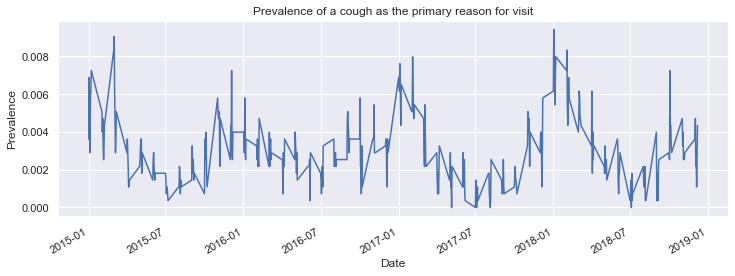

In [17]:
syndromic_features['RFV_14400.0'].plot(
    title='Prevalence of a cough as the primary reason for visit',
    xlabel='Date',
    ylabel='Prevalence',
    figsize=(12,4)
)

## Training the model

In order to detect the anomalies in syndromic data corresponding to the flu season, the training/test set is restricted to only the non-flu season (May-October). However, we will further restrict the training/test set to only odd-year non-flu seasons with the even-year non-flu seasons reserved as an additional test set. This is done to allow for potential annual differences in syndromic data.

First, the non-flu season data is split into the training and test sets.

In [18]:
non_flu_first_month = 5
non_flu_last_month = 10

X_odd = syndromic_features[
    (syndromic_features.index.month >= non_flu_first_month)
    & (syndromic_features.index.month <= non_flu_last_month)
    & ((syndromic_features.index.year % 2) == 1)
]

X_even = syndromic_features[
    (syndromic_features.index.month >= non_flu_first_month)
    & (syndromic_features.index.month <= non_flu_last_month)
    & ((syndromic_features.index.year % 2) == 0)
]

X_train, X_test = train_test_split(
    X_odd,
    test_size=0.2,
    shuffle=True,
    random_state=13,
)

Next, the autoencoder model is defined.

In [19]:
class Autoencoder(Model):
    def __init__(self, dataset, activation=None):
        super(Autoencoder, self).__init__()
        self.activation = activation
        self.num_features = dataset.shape[1]  
        self.encoder = tf.keras.Sequential([
            layers.Dense(47, activation=self.activation),
            layers.Dense(35, activation=self.activation),
            layers.Dense(23, activation=self.activation),
            layers.Dense(18, activation=self.activation),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(22, activation=self.activation),
            layers.Dense(34, activation=self.activation),
            layers.Dense(46, activation=self.activation),
            layers.Dense(self.num_features, activation=self.activation),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder(syndromic_features, activation='relu')

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanSquaredError(),
    metrics=['mse']
)

Once the model has been defined, it is trained using the training set.

In [20]:
model.fit(
    X_train,
    X_train,
    epochs = 100,
    batch_size = 32,
)

Epoch 1/100
3/3 [==============================] - 0s 998us/step - loss: 3.5181e-04 - mse: 3.5181e-04
Epoch 2/100
3/3 [==============================] - 0s 997us/step - loss: 3.4745e-04 - mse: 3.4745e-04
Epoch 3/100
3/3 [==============================] - 0s 997us/step - loss: 3.4611e-04 - mse: 3.4611e-04
Epoch 4/100
3/3 [==============================] - 0s 1ms/step - loss: 3.4478e-04 - mse: 3.4478e-04
Epoch 5/100
3/3 [==============================] - 0s 998us/step - loss: 3.4449e-04 - mse: 3.4449e-04
Epoch 6/100
3/3 [==============================] - 0s 997us/step - loss: 3.4354e-04 - mse: 3.4354e-04
Epoch 7/100
3/3 [==============================] - 0s 995us/step - loss: 3.4274e-04 - mse: 3.4274e-04
Epoch 8/100
3/3 [==============================] - 0s 1ms/step - loss: 3.4213e-04 - mse: 3.4213e-04
Epoch 9/100
3/3 [==============================] - 0s 997us/step - loss: 3.4154e-04 - mse: 3.4154e-04
Epoch 10/100
3/3 [==============================] - 0s 1ms/step - loss: 3.4071e-04 - m

Finally, the model is run on the test set.

In [21]:
test_error = model.evaluate(
    X_test,
    X_test,
)

1/1 [==============================] - 0s 102ms/step - loss: 1.3755e-04 - mse: 1.3755e-04


In [22]:
syndromic_features['Error'] = syndromic_features.apply(
    lambda row: model.evaluate(
        row.values.reshape(1, 59),
        row.values.reshape(1, 59),
    )[1],
    axis=1,
)

============] - 0s 11ms/step - loss: 1.2589e-05 - mse: 1.2589e-05
1/1 [==============================] - 0s 10ms/step - loss: 2.7083e-05 - mse: 2.7083e-05


Plotting the resulting error.

<AxesSubplot:title={'center':'Auto-encoder error as a function of time'}, xlabel='Date', ylabel='Mean Squared Error'>

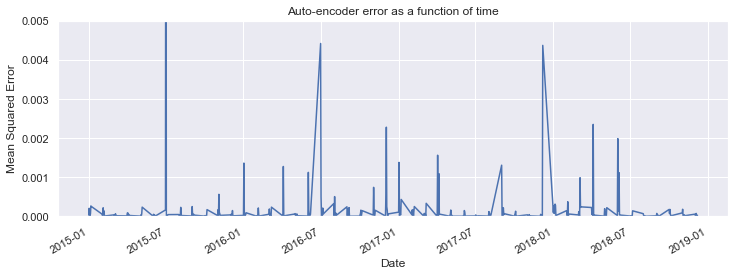

In [23]:
syndromic_features['Error'].plot(
    title='Auto-encoder error as a function of time',
    xlabel='Date',
    ylabel='Mean Squared Error',
    figsize=(12,4),
    ylim=(0, 0.005),
)